## Pre-Trained Model 활용 인터넷 사이트 캡차 숫자인식하기
ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)란 컴퓨터 비전 분야의 '올림픽'으로 불리우는 대회이다. 아마도 딥러닝을 공부한 사람들이라면 한번 쯤 AlexNet이나 VGG, GoogleNet, ResNet에 대해 들어보았을 것이다. 이는 모두 ILSVRC 대회에서 매년 우승을 거머쥐었던 모델이다.
![ImageNet Classfication](images/MicrosoftImagNetResults.png)

출처 : https://www.bdti.com/InsideDSP/2017/06/29/Microsoft

Tranfer Learning과 ILSVRC가 무슨 연관이 있지? 라는 생각이 들텐데, 놀랍게도 우리는 ImageNet Classfication 대회에서 우승했던 모델과 그 가중치를 가져와 쓸 수 있는데, 이것이 바로 앞서 언급 했던 Pre-Trained Model이다.
![ResNet34](images/resnet34.png)

도대체 어떻게하면 이렇게 'Deep한' 모델을 가져다 쓸 수 있을까.

**model_ft = models.resnet18(pretrained=True)** 오늘의 핵심을 단 한 줄로 설명하면 바로 이 코드가 되겠다. torchvision 라이브러리에서는 ResNet 시리즈와 VGG 시리즈 등 ImageNet의 모든 대표작들을 잘 구현해 놓았다. 따라서 우리는 라이브러리에서 꺼내 쓰기만 하면 되는 것이다. 또한 Pre-Trained Weights의 경우, 모델을 불러올 때 파라미터로 pretrained=True 값만 입력해주면 자동으로 Weights 값을 불러올 수 있다.


**```model_ft = models.resnet18(pretrained=True)```**


여기서는 Pre-Trained Model을 캡차 이미지의 숫자인식 성능을 높이기 위해 Weights 값은 제외하고 ResNet에 사용된 알고리즘 모델만 이용 하겠으며,

**```model_ft = models.resnet18(pretrained=False)```**


이상과 같이 pretrained=False로 주고 활용 하게 됩니다.

신경망의 일반적인 학습 과정은 다음과 같습니다:

- 학습 가능한 매개변수(또는 가중치(weight))를 갖는 신경망을 정의합니다.

- 데이터셋(dataset) 입력을 반복합니다.

- 입력을 신경망에서 전파(process)합니다.

- 손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파합니다.

- 신경망의 가중치를 갱신합니다. 일반적으로 다음과 같은 간단한 규칙을 사용합니다: 가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)

In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비



In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET_LEN : 36


### One - Hot Labels

이제 우리의 정답 y를 one hot vector로 바꿉시다.

one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)


In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))


encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 36


### 종속변수 처리를 위한 데이터셋 불러오기
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

* 처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [6]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [7]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [8]:
train_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), transform=transform)
test_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


일부 이미지 시각화하기 ^^^^^^^^^^^^^^^^^^^^^^^^^ 데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

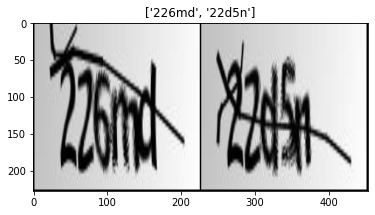

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])



In [10]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]])
torch.Size([64, 1, 224, 224])


In [11]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([64, 180])


In [12]:
print("classes")
print(classes[0])
print(len(classes))

classes
226md
64


### ResNet18 모델기반 신경망 정의하기

이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LEN*MAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LEN*MAX_CAPTCHA가 된다.

In [13]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)


### 손실함수정의

In [14]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기


In [15]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


                                                  
Epoch 1/50
----------


D:\arkwith\captcha\pytorch_env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


step: 1 loss: 0.7205567359924316
step: 2 loss: 0.5158257484436035
step: 3 loss: 0.34949547052383423
step: 4 loss: 0.23965302109718323
step: 5 loss: 0.1786283254623413
step: 6 loss: 0.15223060548305511
step: 7 loss: 0.13313516974449158
step: 8 loss: 0.12501424551010132
step: 9 loss: 0.12287253141403198
step: 10 loss: 0.12688398361206055
step: 11 loss: 0.13125739991664886
step: 12 loss: 0.13547790050506592
step: 13 loss: 0.1368838995695114
step: 14 loss: 0.1312526911497116
step: 15 loss: 0.1306023746728897
step: 16 loss: 0.13209274411201477
                                                  
Epoch 2/50
----------
step: 1 loss: 0.12444198131561279
step: 2 loss: 0.1247255802154541
step: 3 loss: 0.1210322231054306
step: 4 loss: 0.11715327203273773
step: 5 loss: 0.11493508517742157
step: 6 loss: 0.11064693331718445
step: 7 loss: 0.11118702590465546
step: 8 loss: 0.1121915876865387
step: 9 loss: 0.11221777647733688
step: 10 loss: 0.11114291101694107
step: 11 loss: 0.11161944270133972
step: 12 

step: 5 loss: 0.07296711951494217
step: 6 loss: 0.070951908826828
step: 7 loss: 0.07116618007421494
step: 8 loss: 0.0652228519320488
step: 9 loss: 0.06475184857845306
step: 10 loss: 0.06840376555919647
step: 11 loss: 0.06888295710086823
step: 12 loss: 0.07572385668754578
step: 13 loss: 0.06722205877304077
step: 14 loss: 0.06398636847734451
step: 15 loss: 0.07446911185979843
step: 16 loss: 0.06529475003480911
                                                  
Epoch 15/50
----------
step: 1 loss: 0.06844174116849899
step: 2 loss: 0.06853358447551727
step: 3 loss: 0.06450578570365906
step: 4 loss: 0.06425777822732925
step: 5 loss: 0.06791985034942627
step: 6 loss: 0.06491144001483917
step: 7 loss: 0.06507095694541931
step: 8 loss: 0.0601939894258976
step: 9 loss: 0.059724111109972
step: 10 loss: 0.06238850951194763
step: 11 loss: 0.06259378790855408
step: 12 loss: 0.07181069254875183
step: 13 loss: 0.06448029726743698
step: 14 loss: 0.05924683064222336
step: 15 loss: 0.0678953304886818
st

step: 5 loss: 0.020528631284832954
step: 6 loss: 0.024744326248764992
step: 7 loss: 0.02169911377131939
step: 8 loss: 0.017102114856243134
step: 9 loss: 0.016648806631565094
step: 10 loss: 0.015990104526281357
step: 11 loss: 0.020623352378606796
step: 12 loss: 0.027254847809672356
step: 13 loss: 0.024627037346363068
step: 14 loss: 0.015758752822875977
step: 15 loss: 0.01842980645596981
step: 16 loss: 0.02349691279232502
                                                  
Epoch 28/50
----------
step: 1 loss: 0.02176041528582573
step: 2 loss: 0.018264487385749817
step: 3 loss: 0.018041478469967842
step: 4 loss: 0.017284151166677475
step: 5 loss: 0.01660485565662384
step: 6 loss: 0.022073404863476753
step: 7 loss: 0.01835312508046627
step: 8 loss: 0.016069689765572548
step: 9 loss: 0.014920860528945923
step: 10 loss: 0.014742666855454445
step: 11 loss: 0.020010124891996384
step: 12 loss: 0.025716081261634827
step: 13 loss: 0.02308700978755951
step: 14 loss: 0.01281755045056343
step: 15 los

step: 2 loss: 0.0043864985927939415
step: 3 loss: 0.004602405242621899
step: 4 loss: 0.004744383506476879
step: 5 loss: 0.004865426570177078
step: 6 loss: 0.006566043011844158
step: 7 loss: 0.009457999840378761
step: 8 loss: 0.014969105832278728
step: 9 loss: 0.006475026719272137
step: 10 loss: 0.0046043386682868
step: 11 loss: 0.005288158543407917
step: 12 loss: 0.009548739530146122
step: 13 loss: 0.008705232292413712
step: 14 loss: 0.004670056514441967
step: 15 loss: 0.005758943967521191
step: 16 loss: 0.006542948540300131
                                                  
Epoch 41/50
----------
step: 1 loss: 0.0055131264962255955
step: 2 loss: 0.00446124654263258
step: 3 loss: 0.004966038279235363
step: 4 loss: 0.004470751620829105
step: 5 loss: 0.00398627482354641
step: 6 loss: 0.005934719927608967
step: 7 loss: 0.004965974949300289
step: 8 loss: 0.003684788243845105
step: 9 loss: 0.004652959760278463
step: 10 loss: 0.0064246440306305885
step: 11 loss: 0.006560134701430798
step: 12

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
            preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')


### 모델 학습결과 테스트 데이터로 테스트

Lable : xfgxb Prediction Lable : x4dxb 맟춤여부 : False


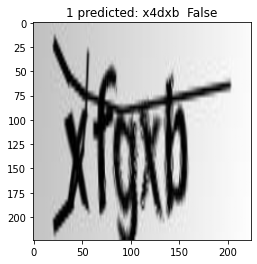

Lable : xfn6n Prediction Lable : x4n6n 맟춤여부 : False


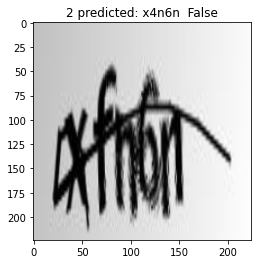

Lable : xgcxy Prediction Lable : xgcyy 맟춤여부 : False


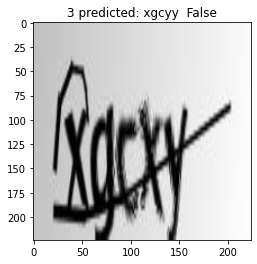

Lable : xmcym Prediction Lable : xwcym 맟춤여부 : False


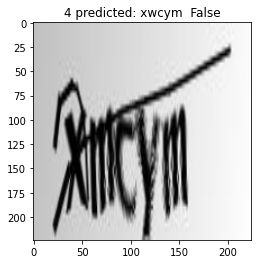

Lable : xnd3y Prediction Lable : x3d5y 맟춤여부 : False


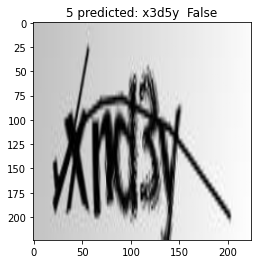

Lable : xnfx5 Prediction Lable : xnfx5 맟춤여부 : True
Lable : xngxc Prediction Lable : xngxc 맟춤여부 : True
Lable : xnn4d Prediction Lable : xnn4d 맟춤여부 : True
Lable : xnnc3 Prediction Lable : xnnc3 맟춤여부 : True
Lable : xp24p Prediction Lable : xp24p 맟춤여부 : True
Lable : xw465 Prediction Lable : xw465 맟춤여부 : True
Lable : xwx7d Prediction Lable : xw67d 맟춤여부 : False
Lable : xxbm5 Prediction Lable : x3bm2 맟춤여부 : False
Lable : xxney Prediction Lable : c3ney 맟춤여부 : False
Lable : xxw44 Prediction Lable : xw3w4 맟춤여부 : False
Lable : xymfn Prediction Lable : xymfn 맟춤여부 : True
Lable : xyncc Prediction Lable : xymcc 맟춤여부 : False
Lable : xyyyw Prediction Lable : xywyw 맟춤여부 : False
Lable : y2436 Prediction Lable : x7436 맟춤여부 : False
Lable : y2xg4 Prediction Lable : x2xp4 맟춤여부 : False
Lable : y2ye8 Prediction Lable : f2ye8 맟춤여부 : False
Lable : y32yy Prediction Lable : f32yy 맟춤여부 : False
Lable : y33nm Prediction Lable : xg3nm 맟춤여부 : False
Lable : y3c58 Prediction Lable : x3c38 맟춤여부 : False
Lable : y48c3 Predi

In [17]:
visualize_model(model)

### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [18]:
torch.save(model.state_dict(), 'model/CaptchaBreaking_Model.pt')
print("save last model")


save last model


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 CaptchaBreaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 CaptchaBreaking_Model.pt를 다시 load하는 것도 가능합니다.

In [19]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/CaptchaBreaking_Model.pt'))
print("load saved_model.")


load saved_model.


업로드한 모델로 다시한번 테스트

Lable : xfgxb Prediction Lable : x4dxb 맟춤여부 : False


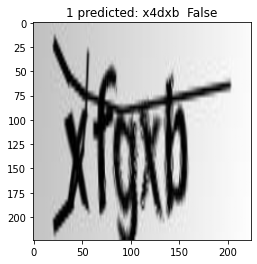

Lable : xfn6n Prediction Lable : x4n6n 맟춤여부 : False


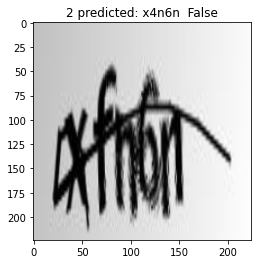

Lable : xgcxy Prediction Lable : xgcyy 맟춤여부 : False


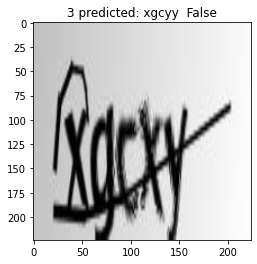

Lable : xmcym Prediction Lable : xwcym 맟춤여부 : False


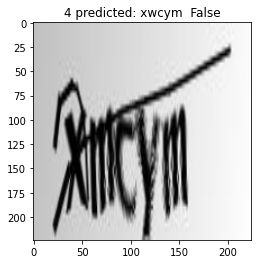

Lable : xnd3y Prediction Lable : x3d5y 맟춤여부 : False


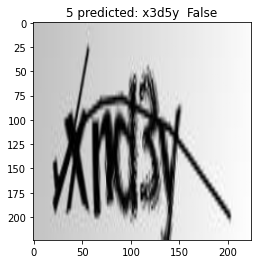

Lable : xnfx5 Prediction Lable : xnfx5 맟춤여부 : True
Lable : xngxc Prediction Lable : xngxc 맟춤여부 : True
Lable : xnn4d Prediction Lable : xnn4d 맟춤여부 : True
Lable : xnnc3 Prediction Lable : xnnc3 맟춤여부 : True
Lable : xp24p Prediction Lable : xp24p 맟춤여부 : True
Lable : xw465 Prediction Lable : xw465 맟춤여부 : True
Lable : xwx7d Prediction Lable : xw67d 맟춤여부 : False
Lable : xxbm5 Prediction Lable : x3bm2 맟춤여부 : False
Lable : xxney Prediction Lable : c3ney 맟춤여부 : False
Lable : xxw44 Prediction Lable : xw3w4 맟춤여부 : False
Lable : xymfn Prediction Lable : xymfn 맟춤여부 : True
Lable : xyncc Prediction Lable : xymcc 맟춤여부 : False
Lable : xyyyw Prediction Lable : xywyw 맟춤여부 : False
Lable : y2436 Prediction Lable : x7436 맟춤여부 : False
Lable : y2xg4 Prediction Lable : x2xp4 맟춤여부 : False
Lable : y2ye8 Prediction Lable : f2ye8 맟춤여부 : False
Lable : y32yy Prediction Lable : f32yy 맟춤여부 : False
Lable : y33nm Prediction Lable : xg3nm 맟춤여부 : False
Lable : y3c58 Prediction Lable : x3c38 맟춤여부 : False
Lable : y48c3 Predi

In [20]:
visualize_model(new_model)

### 학습모델이용 캡차 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

type: <class 'PIL.PngImagePlugin.PngImageFile'>
size of image: (200, 50)


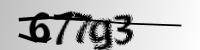

In [21]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('captcha-version-2-images/samples/samples/677g3.png')
# img = Image.open('captcha-version-2-images/captcha01.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [22]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

torch.Size([1, 1, 224, 224])


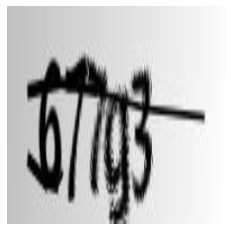

In [23]:
input = process_image('captcha-version-2-images/samples/samples/677g3.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())


In [24]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

   
    return predict_label
    


In [25]:
get_predict(new_model, 'captcha-version-2-images/samples/samples/677g3.png')

torch.Size([1, 1, 224, 224])


'677g3'